<a href="https://colab.research.google.com/github/Asad1287/decision_trees_simulations/blob/main/decision_trees_simulations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Decision Simulation using Discrete Event Simulation


###1. Creating distribution object
Since the model will be probablistic we will first create a scipy wrapper class for distributions creations

In [4]:
!pip install simpy
import simpy
import random
from typing import Generator, Type, Dict, List,Union
import yaml
from abc import ABC, abstractmethod
from scipy import stats
import matplotlib.pyplot as plt
import logging
import yaml
class Distribution:
    def __init__(self, dist_type: str, params: Dict[str, float]):
        self.dist_type = dist_type
        self.params = params
        self.dist = getattr(stats, dist_type)(**params)

    def sample(self) -> float:
        return self.dist.rvs()

def test_uniform_distribution_sampling():
    dist = Distribution('uniform', {'loc': 0, 'scale': 10})
    sample = dist.sample()
    assert isinstance(sample, float)
    assert 0 <= sample <= 10
    print("test success")

def test_exponential_distribution_sampling():
    dist = Distribution('expon', {'scale': 2})
    sample = dist.sample()
    assert isinstance(sample, float)

test_uniform_distribution_sampling()


test success


###2. We will create an entity object to represent the entities entering the simulation, can be modified based on simulation requirements


In [5]:
class EntityItem:
    def __init__(self, name: str, arrival_time: float) -> None:
        self.name = name
        self.arrival_time = arrival_time
        self.start_times = {}
        self.end_times = {}
        self.costs = {}

###2. Create a resource for Simpy
a resource that can process entities (like customers, packets, etc.) in a simulated environment. The class is highly customizable, allowing for a variety of use cases in simulation studies. Below is an explanation of the key components and functionalities of the Resource class:

Constructor Parameters



*   env: A simpy.Environment instance, representing the simulation environment in which the resource operates. It's the context where the simulation runs.
*   capacity: An integer specifying the number of entities the resource can handle simultaneously. It defines the maximum number of parallel operations.
*   service_time_dist: A Distribution instance determining how long it takes to service an entity. This distribution is used to model the variability in service times.
*   cost_dist: Another Distribution instance, this time representing the cost associated with servicing an entity. Like service times, costs are also variable and drawn from this distribution.


*   name: A string to identify the resource. Useful for logging and tracking within a complex simulation.
*   children: An optional list of child Resource instances. These represent any downstream resources that might process an entity after it leaves the current resource. This allows for the modeling of complex, multi-stage processes.

Methods

add_child(self, child: 'Resource', probability: float) -> None: Adds a child resource to the current resource with a specified probability. This method dynamically expands the simulation model by linking resources, potentially with probabilistic branching.

serve(self, entity: EntityItem) -> Generator: This coroutine manages the entire lifecycle of an entity's interaction with the resource. It consists of several steps:


In [6]:
!pip install ipytest
import ipytest
ipytest.autoconfig()
from unittest.mock import Mock, create_autospec
class Resource:
    def __init__(self, env: simpy.Environment, capacity: int, service_time_dist: Distribution, cost_dist: Distribution, name: str,children: List['Resource'] = None) -> None:
        self.env = env
        self.resource = simpy.Resource(env, capacity)
        self.service_time_dist = service_time_dist
        self.cost_dist = cost_dist
        self.name = name
        self.queue_lengths = []
        self.children = children if children is not None else []

    def add_child(self, child: 'Resource', probability: float) -> None:
        self.children.append((child, probability))

    def serve(self, entity: EntityItem) -> Generator:
        with self.resource.request() as req:
            self.queue_lengths.append((self.env.now, len(self.resource.queue)))
            yield req
            entity.start_times[self.name] = self.env.now
            logging.info(f"EntityItem {entity.name} starts {self.name} service at {self.env.now:.2f}")
            service_time = self.service_time_dist.sample()
            yield self.env.timeout(service_time)
            entity.end_times[self.name] = self.env.now
            logging.info(f"EntityItem {entity.name} finishes {self.name} service at {self.env.now:.2f}")
            cost = self.cost_dist.sample()
            entity.costs[self.name] = cost
            logging.info(f"Cost for {entity.name} at {self.name}: {cost:.2f}")
"""
def test_resource_initialization():
    mock_env = Mock(spec=simpy.Environment)
    service_time_dist = Mock(spec=Distribution)
    cost_dist = Mock(spec=Distribution)
    resource = Resource(env=mock_env, capacity=2, service_time_dist=service_time_dist, cost_dist=cost_dist, name="TestResource")

    assert resource.name == "TestResource"
    assert resource.resource.capacity == 2
    assert len(resource.queue_lengths) == 0
    assert len(resource.children) == 0


ipytest.run('-v')
"""

'\ndef test_resource_initialization():\n    mock_env = Mock(spec=simpy.Environment)\n    service_time_dist = Mock(spec=Distribution)\n    cost_dist = Mock(spec=Distribution)\n    resource = Resource(env=mock_env, capacity=2, service_time_dist=service_time_dist, cost_dist=cost_dist, name="TestResource")\n    \n    assert resource.name == "TestResource"\n    assert resource.resource.capacity == 2\n    assert len(resource.queue_lengths) == 0\n    assert len(resource.children) == 0\n\n\nipytest.run(\'-v\')\n'

###3. Creating the Stop Stage and Decision classes

In [7]:
class SimulationStop(Exception):
    pass


class StopStage:
    def __init__(self, name: str):
        self.name = name

    def process(self, env: simpy.Environment, entity: EntityItem) -> Generator:
        print(f"Simulation stopped at {env.now:.2f} due to {self.name}")
        raise SimulationStop
class Decision:
    def __init__(self, probabilities: List[float], resources: List[str]):
        self.probabilities = probabilities
        self.resources = resources

    def choose_resource(self) -> str:
        return random.choices(self.resources, self.probabilities)[0]

"""
# Tests for the Decision class
def test_decision_initialization():
    probabilities = [0.5, 0.5]
    resources = ["Resource1", "Resource2"]
    decision = Decision(probabilities, resources)

    assert decision.probabilities == probabilities
    assert decision.resources == resources

def test_decision_choose_resource_deterministic():
    # Setting the seed to make random choices deterministic for the test
    random.seed(0)
    probabilities = [0.1, 0.9]
    resources = ["Resource1", "Resource2"]
    decision = Decision(probabilities, resources)

    # Since "Resource2" has a higher probability and we set the seed,
    # we expect "Resource2" to be chosen in a deterministic manner.
    chosen_resource = decision.choose_resource()
    assert chosen_resource == "Resource2"

# Execute the tests
ipytest.run('-v')
"""

'\n# Tests for the Decision class\ndef test_decision_initialization():\n    probabilities = [0.5, 0.5]\n    resources = ["Resource1", "Resource2"]\n    decision = Decision(probabilities, resources)\n    \n    assert decision.probabilities == probabilities\n    assert decision.resources == resources\n\ndef test_decision_choose_resource_deterministic():\n    # Setting the seed to make random choices deterministic for the test\n    random.seed(0)\n    probabilities = [0.1, 0.9]\n    resources = ["Resource1", "Resource2"]\n    decision = Decision(probabilities, resources)\n    \n    # Since "Resource2" has a higher probability and we set the seed,\n    # we expect "Resource2" to be chosen in a deterministic manner.\n    chosen_resource = decision.choose_resource()\n    assert chosen_resource == "Resource2"\n\n# Execute the tests\nipytest.run(\'-v\')\n'

### 4. The ProcessFlow class
Orchestrates the flow of entities through a network of resources in a discrete-event simulation environment provided by simpy. It models a process where entities (like products, customers, or data packets) move between different resources (machines, service desks, servers, etc.) based on predefined rules and probabilities

In [8]:
from collections import deque
import ipytest
ipytest.autoconfig()
class ProcessFlow:
    def __init__(self, env: simpy.Environment, resources: Dict[str, Resource], entry_point: str) -> None:
        self.env = env
        self.resources = resources
        self.entry_point = entry_point

    def probabilistic_selection(self, children):
        nodes, probabilities = zip(*children)
        return random.choices(nodes, weights=probabilities, k=1)[0]

    def process(self, entity: EntityItem) -> Generator:
        yield self.env.timeout(entity.arrival_time)
        logging.info(f"EntityItem {entity.name} enters the system at {self.env.now:.2f}")

        visited = set()
        queue = deque([self.entry_point])
        path = []

        while queue:
            current_resource_name = queue.popleft()
            if current_resource_name not in visited:
                visited.add(current_resource_name)
                path.append(current_resource_name)

                current_resource = self.resources[current_resource_name]
                yield from current_resource.serve(entity)

                if current_resource.children:
                    selected_child = self.probabilistic_selection(current_resource.children)
                    queue.append(selected_child.name)

        logging.info(f"EntityItem {entity.name} leaves the system at {self.env.now:.2f}")
        logging.info(f"Path taken: {' -> '.join(path)}")



### 5. The SimulationStats class
It is designed for gathering and presenting statistical data about entities and resources in a simulation. It serves to analyze waiting times, service times, and total costs associated with each resource, as well as providing visualizations for queue lengths and total costs

In [9]:
class SimulationStats:
    def __init__(self, entities: List[EntityItem], resources: List[Resource]) -> None:
        self.entities = entities
        self.resources = resources

    def calculate_stats(self) -> None:
        waiting_times = {}
        service_times = {}


        for entity in self.entities:
            for resource_name in self.resources:
                if resource_name.name in entity.start_times and resource_name.name in entity.end_times:
                    waiting_time = entity.start_times[resource_name.name] - entity.arrival_time
                    service_time = entity.end_times[resource_name.name] - entity.start_times[resource_name.name]

                    if resource_name.name not in waiting_times:
                        waiting_times[resource_name.name] = []
                        service_times[resource_name.name] = []

                    waiting_times[resource_name.name].append(waiting_time)
                    service_times[resource_name.name].append(service_time)
        total_costs = {}
        for entity in self.entities:
            for resource_name, cost in entity.costs.items():
                if resource_name not in total_costs:
                    total_costs[resource_name] = []
                total_costs[resource_name].append(cost)

        print("\nTotal Costs:")
        for resource_name, costs in total_costs.items():
            total_cost = sum(costs)
            print(f"{resource_name}: {total_cost:.2f}")

        self.plot_total_costs(total_costs)

        print("Average Waiting Times:")
        for resource_name, times in waiting_times.items():
            avg_waiting_time = sum(times) / len(times) if times else 0
            print(f"{resource_name}: {avg_waiting_time:.2f}")

        print("\nAverage Service Times:")
        for resource_name, times in service_times.items():
            avg_service_time = sum(times) / len(times) if times else 0
            print(f"{resource_name}: {avg_service_time:.2f}")

    def plot_queue_lengths(self) -> None:
        for resource in self.resources:
            if resource.queue_lengths:
                times, lengths = zip(*resource.queue_lengths)
                plt.figure()
                plt.plot(times, lengths)
                plt.title(f"Queue Length - {resource.name}")
                plt.xlabel("Simulation Time")
                plt.ylabel("Queue Length")
                plt.show()
            else:
                print(f"No queue length data available for {resource.name}")
    def plot_total_costs(self, total_costs: Dict[str, List[float]]) -> None:
        resources = list(total_costs.keys())
        costs = [sum(costs) for costs in total_costs.values()]
        print(f"total costs is {sum(costs)}")
        plt.figure()
        plt.bar(resources, costs)
        plt.title("Total Costs by Resource")
        plt.xlabel("Resource")
        plt.ylabel("Total Cost")
        plt.show()



In [10]:
class Simulation:
    def __init__(self, num_entities: int, resource_configs: Dict[str, Dict], entry_point: str,
                 entity_class: Type[EntityItem], inter_arrival_time_dist: Distribution,return_plots:bool=False):
        self.num_entities = num_entities
        self.resource_configs = resource_configs
        self.entry_point = entry_point
        self.entity_class = entity_class
        self.inter_arrival_time_dist = inter_arrival_time_dist
        self.entities = []
        self.return_plots = return_plots

    def run_simulation(self) -> simpy.Environment:
        env = simpy.Environment()
        resources = {}

        # Create resources without assigning children
        for resource_name, config in self.resource_configs.items():
            service_time_dist = Distribution(config['service_time_dist'], config['service_time_params'])
            cost_dist = Distribution(config['cost_dist'], config['cost_params'])
            resource = Resource(env, config['capacity'], service_time_dist, cost_dist, resource_name)
            resources[resource_name] = resource

        # Assign children to resources
        for resource_name, config in self.resource_configs.items():
            resource = resources[resource_name]
            for child_name, probability in config.get('children', []):
                child_resource = resources[child_name]
                resource.add_child(child_resource, probability)

        process_flow = ProcessFlow(env, resources, self.entry_point)

        for i in range(self.num_entities):
            arrival_time = self.inter_arrival_time_dist.sample()
            entity = self.entity_class(f"Patient {i+1}", arrival_time)
            self.entities.append(entity)
            env.process(process_flow.process(entity))

        try:
            env.run()
        except SimulationStop:
            print("Simulation stopped.")

        if self.return_plots:
           stats = SimulationStats(self.entities, list(resources.values()))
           stats.calculate_stats()
           stats.plot_queue_lengths()
        return env

In [11]:
class Runner:
    def __init__(self, num_simulations: int, num_patients: int, resource_configs: Dict[str, Dict], entry_point: str,
                 entity_class: Type[EntityItem], inter_arrival_time_dist: Distribution) -> None:
        self.num_simulations = num_simulations
        self.num_patients = num_patients
        self.resource_configs = resource_configs
        self.entry_point = entry_point
        self.entity_class = entity_class
        self.inter_arrival_time_dist = inter_arrival_time_dist

    def run_simulations(self) -> None:
        total_costs = []
        total_times = []

        for i in range(self.num_simulations):
            logging.info(f"Running simulation {i+1}/{self.num_simulations}")
            simulation = Simulation(self.num_patients, self.resource_configs, self.entry_point, self.entity_class, self.inter_arrival_time_dist)
            env = simulation.run_simulation()

            total_cost = sum(sum(entity.costs.values()) for entity in simulation.entities)
            total_time = env.now

            total_costs.append(total_cost)
            total_times.append(total_time)

        self.plot_histogram(total_costs, "Total Cost")
        self.plot_histogram(total_times, "Total Time")

        self.fit_distribution(total_costs, "Total Cost")
        self.fit_distribution(total_times, "Total Time")

    def plot_histogram(self, data: List[float], title: str) -> None:
        plt.figure()
        plt.hist(data, bins=20, edgecolor='black')
        plt.title(f"Histogram of {title}")
        plt.xlabel(title)
        plt.ylabel("Frequency")
        plt.show()

    def fit_distribution(self, data: List[float], title: str) -> None:
        dist_names = ['norm', 'expon', 'gamma', 'lognorm', 'weibull_min', 'weibull_max']
        best_dist = None
        best_params = None
        best_sse = float('inf')

        for dist_name in dist_names:
            dist = getattr(stats, dist_name)
            params = dist.fit(data)
            pdf = dist.pdf(data, *params)
            sse = sum((pdf - data) ** 2)

            if sse < best_sse:
                best_dist = dist
                best_params = params
                best_sse = sse

        print(f"\nBest fit distribution for {title}: {best_dist.name}")
        print(f"Distribution parameters: {best_params}")


```yaml
   start:
  capacity: 1
  service_time_dist: uniform
  service_time_params:
    loc: 1
    scale: 2
  cost_dist: uniform
  cost_params:
    loc: 0
    scale: 0
  children:
    - chooseTicketA: 0.5
    - chooseTicketB: 0.5

chooseTicketA:
  capacity: 1
  service_time_dist: uniform
  service_time_params:
    loc: 1
    scale: 2
  cost_dist: uniform
  cost_params:
    loc: -3
    scale: 0
  children:
    - Match1AWin: 0.5
    - Match1BWin: 0.5

chooseTicketB:
  capacity: 1
  service_time_dist: uniform
  service_time_params:
    loc: 2
    scale: 2
  cost_dist: uniform
  cost_params:
    loc: -5
    scale: 0
  children:
    - Match2AWin: 0.5
    - Match2BWin: 0.5

Match1AWin:
  capacity: 1
  service_time_dist: uniform
  service_time_params:
    loc: 2
    scale: 2
  cost_dist: uniform
  cost_params:
    loc: 10
    scale: 0

Match1BWin:
  capacity: 1
  service_time_dist: uniform
  service_time_params:
    loc: 3
    scale: 3
  cost_dist: uniform
  cost_params:
    loc: -5
    scale: 0

Match2AWin:
  capacity: 1
  service_time_dist: uniform
  service_time_params:
    loc: 3
    scale: 3
  cost_dist: uniform
  cost_params:
    loc: -20
    scale: 0

Match2BWin:
  capacity: 1
  service_time_dist: uniform
  service_time_params:
    loc: 3
    scale: 3
  cost_dist: uniform
  cost_params:
    loc: 5
    scale: 0

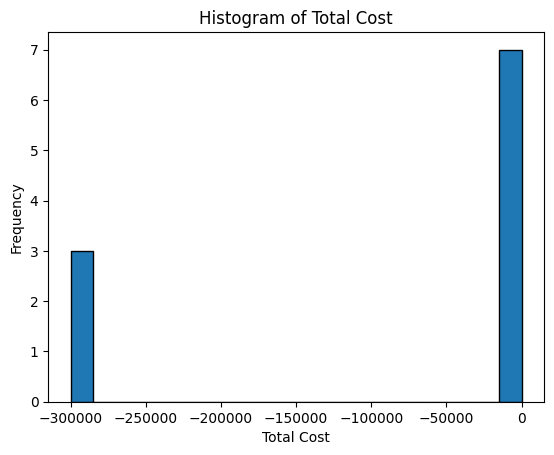

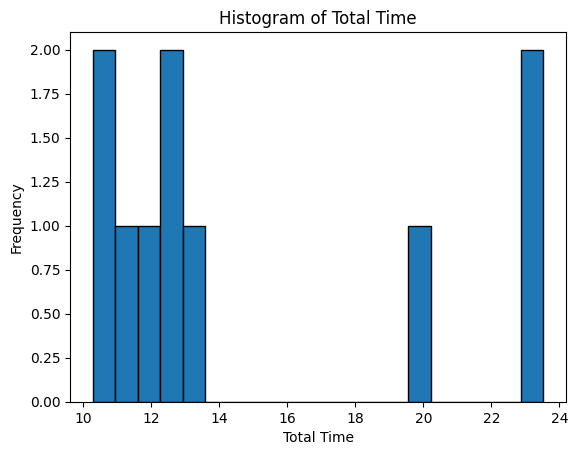


Best fit distribution for Total Cost: weibull_min
Distribution parameters: (112159506.17615552, -9569562106980.984, 9569562077639.59)

Best fit distribution for Total Time: expon
Distribution parameters: (10.287721218220462, 4.64886737530713)


In [19]:

def load_resource_config(file_path):
    with open(file_path, 'r') as file:
        config = yaml.safe_load(file)

    resource_configs = {}
    for resource_name, resource_data in config.items():
        children = [(child_name, probability) for child_data in resource_data.get('children', []) for child_name, probability in child_data.items()]
        resource_configs[resource_name] = {
            'capacity': resource_data['capacity'],
            'service_time_dist': resource_data['service_time_dist'],
            'service_time_params': resource_data['service_time_params'],
            'cost_dist': resource_data['cost_dist'],
            'cost_params': resource_data['cost_params'],
            'children': children
        }

    return resource_configs

if __name__ == "__main__":
    num_simulations = 10
    num_entities_per_sim = 1
    file_path = 'simulation.yaml'
    resource_configs = load_resource_config(file_path)

    entry_point = 'start'
    inter_arrival_time_dist = Distribution('uniform', {'loc': 0, 'scale': 5})

    runner = Runner(num_simulations, num_entities_per_sim, resource_configs, entry_point, EntityItem, inter_arrival_time_dist)
    runner.run_simulations()

### Example Oil Drilling Case study:

start:
  capacity: 1
  service_time_dist: uniform
  service_time_params:
    loc: 1
    scale: 2
  cost_dist: uniform
  cost_params:
    loc: 0
    scale: 0
  children:
    - Test: 0.25
    - DontTest: 0.75

Test:
  capacity: 1
  service_time_dist: uniform
  service_time_params:
    loc: 10
    scale: 2
  cost_dist: uniform
  cost_params:
    loc: -300000
    scale: 0
  children:
    - None: 0.25
    - Open: 0.25
    - Closed: 0.5

DontTest:
  capacity: 1
  service_time_dist: uniform
  service_time_params:
    loc: 2
    scale: 2
  cost_dist: uniform
  cost_params:
    loc: -5
    scale: 0
  children:
    - Drill: 0.5
    - DontDrill: 0.5

None:
  capacity: 1
  service_time_dist: uniform
  service_time_params:
    loc: 2
    scale: 2
  cost_dist: uniform
  cost_params:
    loc: 10
    scale: 0
  children:
    - Drill: 0.5
    - DontDrill: 0.5

Open:
  capacity: 1
  service_time_dist: uniform
  service_time_params:
    loc: 2
    scale: 2
  cost_dist: uniform
  cost_params:
    loc: 10
    scale: 0
  children:
    - Drill: 0.5
    - DontDrill: 0.5

Closed:
  capacity: 1
  service_time_dist: uniform
  service_time_params:
    loc: 2
    scale: 2
  cost_dist: uniform
  cost_params:
    loc: 10
    scale: 0
  children:
    - Drill: 0.5
    - DontDrill: 0.5

Drill:
  capacity: 1
  service_time_dist: uniform
  service_time_params:
    loc: 2
    scale: 2
  cost_dist: uniform
  cost_params:
    loc: 10
    scale: 0
  children:
    - Dry: 0.3
    - Wet: 0.2
    - Soaking: 0.5

DontDrill:
  capacity: 1
  service_time_dist: uniform
  service_time_params:
    loc: 2
    scale: 2
  cost_dist: uniform
  cost_params:
    loc: 10
    scale: 0

Dry:
  capacity: 1
  service_time_dist: uniform
  service_time_params:
    loc: 2
    scale: 2
  cost_dist: uniform
  cost_params:
    loc: 10
    scale: 0

Wet:
  capacity: 1
  service_time_dist: uniform
  service_time_params:
    loc: 2
    scale: 2
  cost_dist: uniform
  cost_params:
    loc: 10
    scale: 0

Soaking:
  capacity: 1
  service_time_dist: uniform
  service_time_params:
    loc: 2
    scale: 2
  cost_dist: uniform
  cost_params:
    loc: 10
    scale: 0




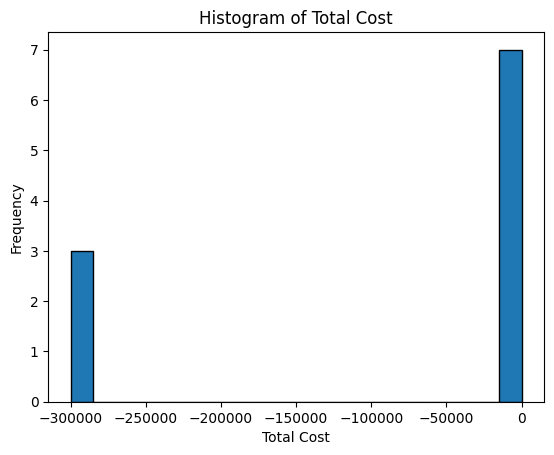

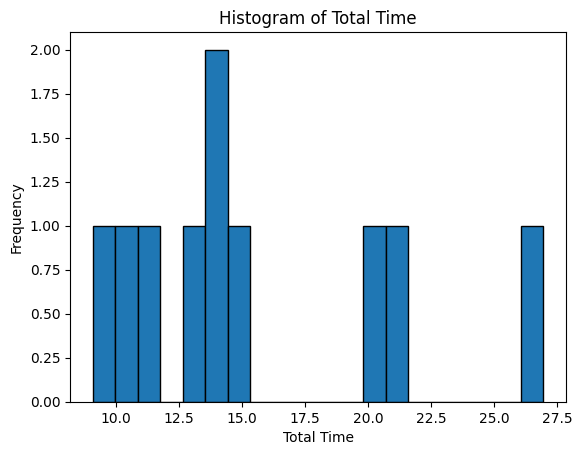


Best fit distribution for Total Cost: weibull_min
Distribution parameters: (86502711.8761599, -7380408926368.059, 7380408897025.547)

Best fit distribution for Total Time: expon
Distribution parameters: (9.076984669718197, 6.334794507424389)


In [20]:
def load_resource_config(file_path):
    with open(file_path, 'r') as file:
        config = yaml.safe_load(file)

    resource_configs = {}
    for resource_name, resource_data in config.items():
        children = [(child_name, probability) for child_data in resource_data.get('children', []) for child_name, probability in child_data.items()]
        resource_configs[resource_name] = {
            'capacity': resource_data['capacity'],
            'service_time_dist': resource_data['service_time_dist'],
            'service_time_params': resource_data['service_time_params'],
            'cost_dist': resource_data['cost_dist'],
            'cost_params': resource_data['cost_params'],
            'children': children
        }

    return resource_configs

if __name__ == "__main__":
    num_simulations = 10
    num_entities_per_sim = 1
    file_path = 'simulation.yaml'
    resource_configs = load_resource_config(file_path)

    entry_point = 'start'
    inter_arrival_time_dist = Distribution('uniform', {'loc': 0, 'scale': 5})

    runner = Runner(num_simulations, num_entities_per_sim, resource_configs, entry_point, EntityItem, inter_arrival_time_dist)
    runner.run_simulations()